In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report, RocCurveDisplay, ConfusionMatrixDisplay

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
file_path = '/content/drive/MyDrive/DataScience_Luluah/train.csv'
df = pd.read_csv(file_path)

In [4]:
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,bookingID
0,"Crystal Cove, Barbados Barbados",0,8,2019,January,2,10,0,4,2,...,314.0,NaN,0,Transient,38.40,0,0,Check-Out,2019-01-14,1
1,"Greensboro Courtyard Greensboro, NC",1,524,2018,December,51,15,0,2,2,...,1.0,NaN,0,Transient,62.80,0,0,Canceled,2017-10-21,2
2,"The Westin Peachtree Plaza, Atlanta Atlanta, GA",1,175,2019,May,20,19,1,2,2,...,12.0,NaN,0,Transient,110.00,0,0,Canceled,2018-11-25,3
3,Courtyard by Marriott Aberdeen Airport Aberdee...,0,0,2018,October,43,17,1,0,1,...,NaN,200.0,0,Transient,45.00,0,0,Check-Out,2018-10-18,4
4,"W New York – Union Square New York, NY",1,33,2017,September,39,26,2,3,2,...,16.0,NaN,0,Transient,57.92,0,1,Canceled,2017-08-24,5


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83293 entries, 0 to 83292
Data columns (total 33 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   hotel                           83293 non-null  object 
 1   is_canceled                     83293 non-null  int64  
 2   lead_time                       83293 non-null  int64  
 3   arrival_date_year               83293 non-null  int64  
 4   arrival_date_month              83293 non-null  object 
 5   arrival_date_week_number        83293 non-null  int64  
 6   arrival_date_day_of_month       83293 non-null  int64  
 7   stays_in_weekend_nights         83293 non-null  int64  
 8   stays_in_week_nights            83293 non-null  int64  
 9   adults                          83293 non-null  int64  
 10  children                        83290 non-null  float64
 11  babies                          83293 non-null  int64  
 12  meal                            

DATA CLEANING

In [6]:
len(df.drop_duplicates()) / len(df)

1.0

CHECK MISSING VALUE

In [7]:
print("\nMissing Values per Column:")
df.isnull().sum()


Missing Values per Column:


,0
hotel,0
is_canceled,0
lead_time,0
arrival_date_year,0
arrival_date_month,0
arrival_date_week_number,0
arrival_date_day_of_month,0
stays_in_weekend_nights,0
stays_in_week_nights,0
adults,0


In [8]:
# percentage version
total_rows = len(df)

# Menghitung dan menampilkan persentase missing values di setiap kolom satu per satu
for column in df.columns:
    missing_count = df[column].isna().sum()
    missing_percentage = (missing_count / total_rows) * 100
    print(f"Column '{column}' Has {missing_count} missing values ({missing_percentage:.2f}%)") # .2f means 2 decimal

Column 'hotel' Has 0 missing values (0.00%)
Column 'is_canceled' Has 0 missing values (0.00%)
Column 'lead_time' Has 0 missing values (0.00%)
Column 'arrival_date_year' Has 0 missing values (0.00%)
Column 'arrival_date_month' Has 0 missing values (0.00%)
Column 'arrival_date_week_number' Has 0 missing values (0.00%)
Column 'arrival_date_day_of_month' Has 0 missing values (0.00%)
Column 'stays_in_weekend_nights' Has 0 missing values (0.00%)
Column 'stays_in_week_nights' Has 0 missing values (0.00%)
Column 'adults' Has 0 missing values (0.00%)
Column 'children' Has 3 missing values (0.00%)
Column 'babies' Has 0 missing values (0.00%)
Column 'meal' Has 0 missing values (0.00%)
Column 'country' Has 346 missing values (0.42%)
Column 'market_segment' Has 0 missing values (0.00%)
Column 'distribution_channel' Has 0 missing values (0.00%)
Column 'is_repeated_guest' Has 0 missing values (0.00%)
Column 'previous_cancellations' Has 0 missing values (0.00%)
Column 'previous_bookings_not_canceled' 

In [9]:
# Drop the 'company' column due to excessive missing values
df.drop('company', axis=1, inplace=True)

# Fill missing values in 'agent' with 0
df['agent'] = df['agent'].fillna(0)

# Fill missing values in 'country' with 'Unknown'
df['country'] = df['country'].fillna('Unknown')

# Fill missing values in 'children' with 0
df['children'] = df['children'].fillna(0)

In [10]:
print("\nMissing Values per Column:")
df.isnull().sum()


Missing Values per Column:


,0
hotel,0
is_canceled,0
lead_time,0
arrival_date_year,0
arrival_date_month,0
arrival_date_week_number,0
arrival_date_day_of_month,0
stays_in_weekend_nights,0
stays_in_week_nights,0
adults,0


OUTLIER

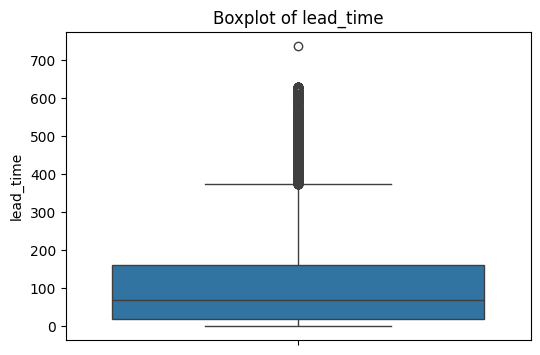

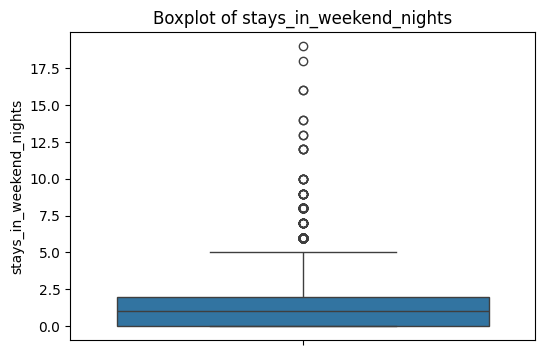

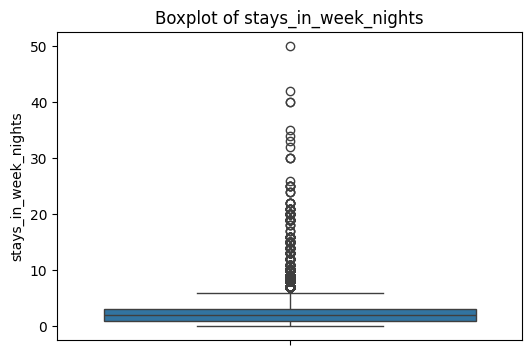

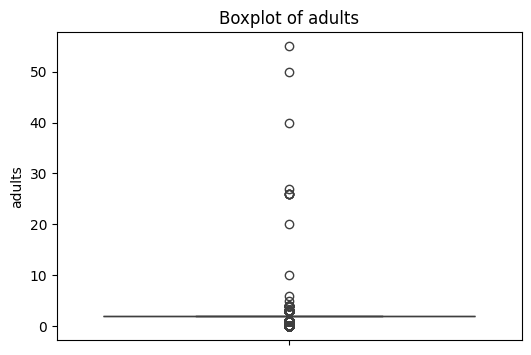

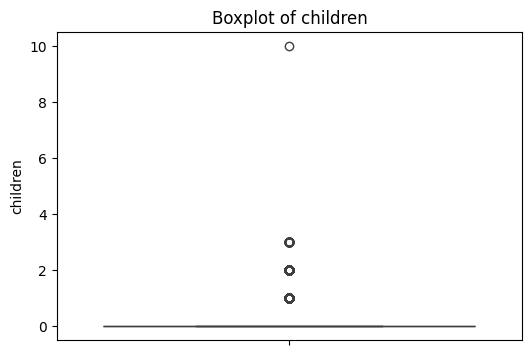

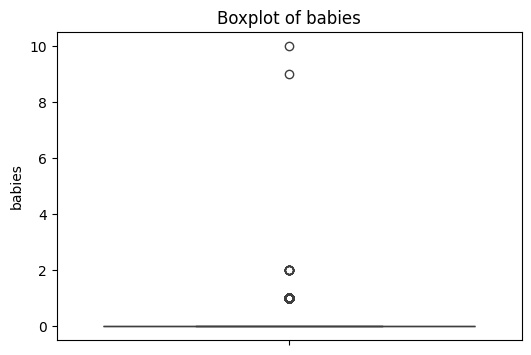

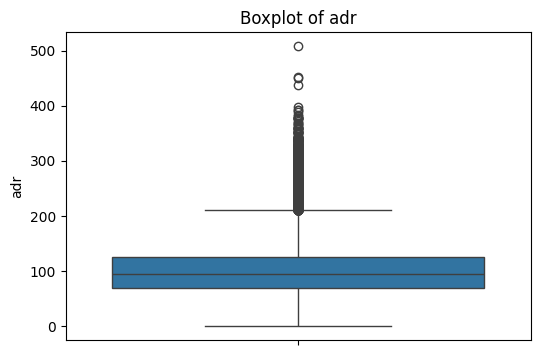

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

def check_boxplot(df, variable):
    plt.figure(figsize=(6, 4))
    sns.boxplot(y=df[variable])
    plt.title(f'Boxplot of {variable}')
    plt.show()

# Example usage for multiple numerical columns:
num_cols = ['lead_time', 'stays_in_weekend_nights', 'stays_in_week_nights',
            'adults', 'children', 'babies', 'adr']

for col in num_cols:
    check_boxplot(df, col)

In [12]:
df['arrival_date'] = pd.to_datetime(
    df['arrival_date_year'].astype(str) + '-' +
    df['arrival_date_month'].astype(str) + '-' +
    df['arrival_date_day_of_month'].astype(str),
    errors='coerce'
)

# Ubah kolom reservation_status_date ke datetime
df['reservation_status_date'] = pd.to_datetime(df['reservation_status_date'])

# Hitung selisih hari antara arrival_date dan reservation_status_date
df['lead_time_calc'] = (df['arrival_date'] - df['reservation_status_date']).dt.days

# Bandingkan dengan lead_time asli
df['lead_time_diff'] = df['lead_time'] - df['lead_time_calc']

# Cek baris dengan lead_time sangat besar
df[df['lead_time'] > 365][['lead_time', 'lead_time_calc', 'lead_time_diff', 'arrival_date', 'reservation_status_date']].head()


,lead_time,lead_time_calc,lead_time_diff,arrival_date,reservation_status_date
1,524,420.0,104.0,2018-12-15,2017-10-21
5,395,223.0,172.0,2018-03-21,2017-08-10
60,405,-2.0,407.0,2019-07-04,2019-07-06
78,396,-2.0,398.0,2019-06-25,2019-06-27
122,448,-3.0,451.0,2019-06-17,2019-06-20


In [13]:
def check_outliers_text(df, variables):

    for col in variables:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower) | (df[col] > upper)][col]
        print(f"Column '{col}': {len(outliers)} outliers")
        print(f"  Lower bound: {lower:.2f}, Upper bound: {upper:.2f}")
        print(f"  Min: {df[col].min()}, Max: {df[col].max()}")
        if len(outliers) > 0:
            print(f"  Example outlier values: {outliers.unique()[:100]}")
        print("-" * 50)

# Example usage:
num_cols = ['lead_time', 'stays_in_weekend_nights', 'stays_in_week_nights',
            'adults', 'children', 'babies', 'adr']

check_outliers_text(df, num_cols)


Column 'lead_time': 2112 outliers
  Lower bound: -195.00, Upper bound: 373.00
  Min: 0, Max: 737
  Example outlier values: [524 395 405 396 448 385 411 429 489 468 443 386 393 387 377 629 447 378
 457 440 507 542 420 464 521 465 423 504 379 479 433 594 398 390 437 605
 461 407 414 566 418 444 454 409 381 531 545 622 374 462 434 391 426 573
 518 587 496 490 383 608 422 626 408 450 451 552 419 559 394 475 397 399
 580 412 410 406 601 503 476 482 478 388 532 510 467 517 471 389 463 538
 382 615 403 460 493 445 384 376 400 737]
--------------------------------------------------
Column 'stays_in_weekend_nights': 196 outliers
  Lower bound: -3.00, Upper bound: 5.00
  Min: 0, Max: 19
  Example outlier values: [ 6  8  9 19 12 10  7 18 14 16 13]
--------------------------------------------------
Column 'stays_in_week_nights': 2355 outliers
  Lower bound: -2.00, Upper bound: 6.00
  Min: 0, Max: 50
  Example outlier values: [10  7  8 19  9 11 14 21 20 50 15 16 12 30 26 13 24 25 22 18 17 42 35 40


In [14]:
import pandas as pd
import numpy as np

# Load your dataset (replace with your actual file path)
# df = pd.read_csv('your_data.csv')

# 1. Check for bookings where adults = 0 (invalid or placeholder data)
invalid_adults = df[df['adults'] == 0]
print(f"Number of bookings with adults=0: {len(invalid_adults)}")
if len(invalid_adults) > 0:
    print(invalid_adults[['adults', 'children', 'babies', 'bookingID']].head())

# 2. Check for illogical combinations: children/babies without adults
invalid_kids = df[(df['adults'] == 0) & ((df['children'] > 0) | (df['babies'] > 0))]
print(f"Number of bookings with 0 adults but with children/babies: {len(invalid_kids)}")
if len(invalid_kids) > 0:
    print(invalid_kids[['adults', 'children', 'babies', 'bookingID']].head())

# 3. Check for negative values in key numeric columns
num_cols = ['lead_time', 'stays_in_weekend_nights', 'stays_in_week_nights',
            'adults', 'children', 'babies', 'adr']
for col in num_cols:
    neg_count = (df[col] < 0).sum()
    print(f"Number of negative values in column '{col}': {neg_count}")

# 4. Check for extreme outliers in people count (>20)
for col in ['adults', 'children', 'babies']:
    extreme = df[df[col] > 20]
    print(f"Number of records with {col} > 20: {len(extreme)}")
    if len(extreme) > 0:
        print(extreme[[col, 'bookingID']].head())

# 5. Check for extremely high ADR (e.g., >1000)
adr_extreme = df[df['adr'] > 1000]
print(f"Number of bookings with ADR > 1000: {len(adr_extreme)}")
if len(adr_extreme) > 0:
    print(adr_extreme[['adr', 'bookingID']].head())

# 6. Build arrival_date from year, month, day columns
df['arrival_date'] = pd.to_datetime(
    df['arrival_date_year'].astype(str) + '-' +
    df['arrival_date_month'].astype(str) + '-' +
    df['arrival_date_day_of_month'].astype(str),
    errors='coerce'
)

# Convert reservation_status_date to datetime
df['reservation_status_date'] = pd.to_datetime(df['reservation_status_date'], errors='coerce')

# 7. Calculate lead_time_calc only when reservation_status_date < arrival_date
df['lead_time_calc'] = (
    df.apply(
        lambda row: (row['arrival_date'] - row['reservation_status_date']).days
        if pd.notna(row['arrival_date']) and pd.notna(row['reservation_status_date'])
        and row['reservation_status_date'] < row['arrival_date']
        else np.nan,
        axis=1
    )
)

# 8. Compute difference between original lead_time and calculated one
df['lead_time_diff'] = df['lead_time'] - df['lead_time_calc']

# 9. Identify invalid bookings where reservation_status_date >= arrival_date
invalid_bookings = df[df['reservation_status_date'] >= df['arrival_date']]
print(f"Number of logically invalid bookings (reservation after arrival): {len(invalid_bookings)}")

# Show example of invalid data
if len(invalid_bookings) > 0:
    print("Examples of invalid bookings:")
    print(invalid_bookings[['reservation_status_date', 'arrival_date', 'bookingID']].head(10))

# 10. Use only valid bookings for further analysis
valid_bookings = df[df['reservation_status_date'] < df['arrival_date']]

# Recalculate lead_time_diff on valid data
valid_bookings['lead_time_diff'] = valid_bookings['lead_time'] - valid_bookings['lead_time_calc']

# 11. Flag bookings with large differences (>30 days)
lead_time_error = valid_bookings[valid_bookings['lead_time_diff'].abs() > 30]
print(f"Number of bookings with inconsistent lead_time (>30 days difference): {len(lead_time_error)}")

# Show example of inconsistencies
if len(lead_time_error) > 0:
    print("Examples of inconsistent lead_time:")
    print(lead_time_error[['lead_time', 'lead_time_calc', 'lead_time_diff', 'arrival_date', 'reservation_status_date', 'bookingID']].head(10))

Number of bookings with adults=0: 287
      adults  children  babies  bookingID
43         0       3.0       0         44
47         0       2.0       0         48
257        0       2.0       0        258
1377       0       0.0       0       1378
1521       0       2.0       0       1522
Number of bookings with 0 adults but with children/babies: 160
      adults  children  babies  bookingID
43         0       3.0       0         44
47         0       2.0       0         48
257        0       2.0       0        258
1521       0       2.0       0       1522
2329       0       2.0       0       2330
Number of negative values in column 'lead_time': 0
Number of negative values in column 'stays_in_weekend_nights': 0
Number of negative values in column 'stays_in_week_nights': 0
Number of negative values in column 'adults': 0
Number of negative values in column 'children': 0
Number of negative values in column 'babies': 0
Number of negative values in column 'adr': 0
Number of records with adu

In [15]:
df.isnull().sum()

,0
hotel,0
is_canceled,0
lead_time,0
arrival_date_year,0
arrival_date_month,0
arrival_date_week_number,0
arrival_date_day_of_month,0
stays_in_weekend_nights,0
stays_in_week_nights,0
adults,0


In [16]:
# Filter bookings with adults > 20
large_adult_bookings = df[df['adults'] > 20][['adults', 'market_segment', 'customer_type', 'bookingID']]

# Display the result for inspection
print(large_adult_bookings)

# Check summary of market_segment and customer_type for large bookings
print("\nDistribution of market_segment for adults > 20:")
print(large_adult_bookings['market_segment'].value_counts())

print("\nDistribution of customer_type for adults > 20:")
print(large_adult_bookings['customer_type'].value_counts())


       adults market_segment customer_type  bookingID
4242       50         Direct         Group       4243
28122      26  Offline TA/TO         Group      28123
28470      27         Direct         Group      28471
38011      40         Direct         Group      38012
39003      26  Offline TA/TO         Group      39004
39547      26  Offline TA/TO         Group      39548
55758      26  Offline TA/TO         Group      55759
65582      55         Direct         Group      65583
68235      26  Offline TA/TO         Group      68236

Distribution of market_segment for adults > 20:
market_segment
Offline TA/TO    5
Direct           4
Name: count, dtype: int64

Distribution of customer_type for adults > 20:
customer_type
Group    9
Name: count, dtype: int64


drop adult = 0

In [17]:
# Remove all rows where adults == 0
df = df[df['adults'] > 0].copy()

In [18]:
# Check if there are still any rows with adults == 0
num_adults_zero = (df['adults'] == 0).sum()
print(f"Number of bookings with adults=0: {num_adults_zero}")

# Optionally, display the rows if any are found
if num_adults_zero > 0:
    print(df[df['adults'] == 0])
else:
    print("No bookings with adults = 0 remain in the dataset.")

Number of bookings with adults=0: 0
No bookings with adults = 0 remain in the dataset.


In [19]:
import pandas as pd

# 1. Descriptive statistics: mean, median, mode, std (rounded for readability)
desc_stats = df[num_cols].describe().T
desc_stats['median'] = df[num_cols].median()
desc_stats['mode'] = df[num_cols].mode().iloc[0]
desc_stats = desc_stats[['mean', 'median', 'mode', 'std', 'min', '25%', '50%', '75%', 'max']]
desc_stats = desc_stats.round(2)
print("Descriptive statistics for key numeric columns:\n")
for col in desc_stats.index:
    print(f"{col.capitalize()}:")
    print(f"  Mean: {desc_stats.loc[col, 'mean']}")
    print(f"  Median: {desc_stats.loc[col, 'median']}")
    print(f"  Mode: {desc_stats.loc[col, 'mode']}")
    print(f"  Std: {desc_stats.loc[col, 'std']}")
    print(f"  Min: {desc_stats.loc[col, 'min']}, Max: {desc_stats.loc[col, 'max']}")
    print(f"  25%: {desc_stats.loc[col, '25%']}, 50%: {desc_stats.loc[col, '50%']}, 75%: {desc_stats.loc[col, '75%']}")
    print("")

# 2. Average ADR by hotel type (top 10, rounded)
adr_by_hotel = df.groupby('hotel')['adr'].mean().sort_values(ascending=False).round(2)
print("Top 10 Hotels by Average ADR:")
print(adr_by_hotel.head(10).to_string())
print("")

# 3. Cancellation rate by market segment (as percentage, with total/canceled counts)
segment_counts = df.groupby('market_segment')['bookingID'].count()
canceled_counts = df[df['is_canceled'] == 1].groupby('market_segment')['bookingID'].count()
cancel_rate = (canceled_counts / segment_counts * 100).round(1)

print("Cancellation rate by market segment (%):")
for seg in segment_counts.index:
    total = segment_counts[seg]
    canceled = canceled_counts.get(seg, 0)
    rate = cancel_rate.get(seg, 0)
    print(f"  {seg}: {rate}% (From the total {total:,} bookings, {canceled:,} were canceled)")
print("")

# 4. Booking counts by customer type
customer_segment = df['customer_type'].value_counts()
print("Booking counts by customer type:")
for seg, val in customer_segment.items():
    print(f"  {seg}: {val:,}")


Descriptive statistics for key numeric columns:

Lead_time:
  Mean: 103.97
  Median: 69.0
  Mode: 0.0
  Std: 106.91
  Min: 0.0, Max: 737.0
  25%: 18.0, 50%: 69.0, 75%: 160.0

Stays_in_weekend_nights:
  Mean: 0.93
  Median: 1.0
  Mode: 0.0
  Std: 1.0
  Min: 0.0, Max: 19.0
  25%: 0.0, 50%: 1.0, 75%: 2.0

Stays_in_week_nights:
  Mean: 2.5
  Median: 2.0
  Mode: 2.0
  Std: 1.92
  Min: 0.0, Max: 50.0
  25%: 1.0, 50%: 2.0, 75%: 3.0

Adults:
  Mean: 1.86
  Median: 2.0
  Mode: 2.0
  Std: 0.6
  Min: 1.0, Max: 55.0
  25%: 2.0, 50%: 2.0, 75%: 2.0

Children:
  Mean: 0.1
  Median: 0.0
  Mode: 0.0
  Std: 0.39
  Min: 0.0, Max: 10.0
  25%: 0.0, 50%: 0.0, 75%: 0.0

Babies:
  Mean: 0.01
  Median: 0.0
  Mode: 0.0
  Std: 0.1
  Min: 0.0, Max: 10.0
  25%: 0.0, 50%: 0.0, 75%: 0.0

Adr:
  Mean: 101.9
  Median: 94.96
  Mode: 62.0
  Std: 47.99
  Min: 0.0, Max: 508.0
  25%: 70.0, 50%: 94.96, 75%: 126.0

Top 10 Hotels by Average ADR:
hotel
Renaissance Santo Domingo Jaragua Hotel & Casino Santo Domingo, Dominican R

cek ulang dataset untuk missing value nya


In [20]:
print("\nMissing Values per Column:")
df.isnull().sum()


Missing Values per Column:


,0
hotel,0
is_canceled,0
lead_time,0
arrival_date_year,0
arrival_date_month,0
arrival_date_week_number,0
arrival_date_day_of_month,0
stays_in_weekend_nights,0
stays_in_week_nights,0
adults,0


In [21]:
# percentage version
total_rows = len(df)

# Menghitung dan menampilkan persentase missing values di setiap kolom satu per satu
for column in df.columns:
    missing_count = df[column].isna().sum()
    missing_percentage = (missing_count / total_rows) * 100
    print(f"Column '{column}' Has {missing_count} missing values ({missing_percentage:.2f}%)") # .2f means 2 decimal

Column 'hotel' Has 0 missing values (0.00%)
Column 'is_canceled' Has 0 missing values (0.00%)
Column 'lead_time' Has 0 missing values (0.00%)
Column 'arrival_date_year' Has 0 missing values (0.00%)
Column 'arrival_date_month' Has 0 missing values (0.00%)
Column 'arrival_date_week_number' Has 0 missing values (0.00%)
Column 'arrival_date_day_of_month' Has 0 missing values (0.00%)
Column 'stays_in_weekend_nights' Has 0 missing values (0.00%)
Column 'stays_in_week_nights' Has 0 missing values (0.00%)
Column 'adults' Has 0 missing values (0.00%)
Column 'children' Has 0 missing values (0.00%)
Column 'babies' Has 0 missing values (0.00%)
Column 'meal' Has 0 missing values (0.00%)
Column 'country' Has 0 missing values (0.00%)
Column 'market_segment' Has 0 missing values (0.00%)
Column 'distribution_channel' Has 0 missing values (0.00%)
Column 'is_repeated_guest' Has 0 missing values (0.00%)
Column 'previous_cancellations' Has 0 missing values (0.00%)
Column 'previous_bookings_not_canceled' Ha

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 83006 entries, 0 to 83292
Data columns (total 35 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   hotel                           83006 non-null  object        
 1   is_canceled                     83006 non-null  int64         
 2   lead_time                       83006 non-null  int64         
 3   arrival_date_year               83006 non-null  int64         
 4   arrival_date_month              83006 non-null  object        
 5   arrival_date_week_number        83006 non-null  int64         
 6   arrival_date_day_of_month       83006 non-null  int64         
 7   stays_in_weekend_nights         83006 non-null  int64         
 8   stays_in_week_nights            83006 non-null  int64         
 9   adults                          83006 non-null  int64         
 10  children                        83006 non-null  float64       
 11  babies 

In [23]:
# Impute missing values for arrival_date using forward fill then backward fill
df['arrival_date'] = df['arrival_date'].ffill().bfill()

# Impute missing values for lead_time_calc and lead_time_diff using the median
lead_time_calc_median = df['lead_time_calc'].median()
lead_time_diff_median = df['lead_time_diff'].median()

df['lead_time_calc'] = df['lead_time_calc'].fillna(lead_time_calc_median)
df['lead_time_diff'] = df['lead_time_diff'].fillna(lead_time_diff_median)

# Verify that there are no missing values left
print(df[['arrival_date', 'lead_time_calc', 'lead_time_diff']].isnull().sum())


arrival_date      0
lead_time_calc    0
lead_time_diff    0
dtype: int64


In [24]:
# Filter rows where adr is 0
adr_zero = df[df['adr'] == 0]

# Check for cases where reservation_status = "Canceled" or is_canceled = 1 (ADR = 0 is valid)
valid_canceled = adr_zero[(df['reservation_status'] == 'Canceled') | (df['is_canceled'] == 1)]

# Check for cases where reservation_status = "Check-Out" and ADR = 0 (likely complimentary or data error)
suspected_error = adr_zero[(df['reservation_status'] == 'Check-Out')]

# Display the valid canceled bookings
print("Valid Canceled Bookings (ADR = 0):")
print(valid_canceled[['adr', 'reservation_status', 'is_canceled', 'bookingID']].head(250))

# Display the suspected data error or complimentary bookings
print("\nSuspected Complimentary or Data Error (ADR = 0):")
print(suspected_error[['adr', 'reservation_status', 'is_canceled', 'bookingID']].head(250))


Valid Canceled Bookings (ADR = 0):
       adr reservation_status  is_canceled  bookingID
154    0.0           Canceled            1        155
729    0.0            No-Show            1        730
810    0.0           Canceled            1        811
2258   0.0           Canceled            1       2259
2522   0.0            No-Show            1       2523
...    ...                ...          ...        ...
78557  0.0           Canceled            1      78558
80114  0.0            No-Show            1      80115
81653  0.0            No-Show            1      81654
82821  0.0           Canceled            1      82822
83163  0.0           Canceled            1      83164

[120 rows x 4 columns]

Suspected Complimentary or Data Error (ADR = 0):
       adr reservation_status  is_canceled  bookingID
71     0.0          Check-Out            0         72
131    0.0          Check-Out            0        132
163    0.0          Check-Out            0        164
252    0.0          Check-O

In [25]:
# Hapus baris dengan adr = 0 dan reservation_status == "Check-Out"
df_clean = df[~((df['adr'] == 0) & (df['reservation_status'] == "Check-Out"))].copy()


In [26]:
# # Export the cleaned DataFrame to an Excel file
df_clean.to_excel('Study_final.xlsx', index=False)

MAchine learning

In [27]:
import re
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import lightgbm as lgb
from xgboost import XGBRegressor

# Enhanced column cleaning with duplicate handling
def clean_column_names(df):
    # Remove special characters and replace with underscore
    new_columns = [re.sub(r'[^a-zA-Z0-9_]', '_', col) for col in df.columns]
    # Handle duplicate column names
    seen = {}
    dedup_columns = []
    for col in new_columns:
        if col in seen:
            seen[col] += 1
            dedup_col = f"{col}_{seen[col]}"
        else:
            seen[col] = 1
            dedup_col = col
        dedup_columns.append(dedup_col)
    df.columns = dedup_columns
    return df

# Clean all datasets
df = clean_column_names(df)
feature_train = clean_column_names(feature_train)
feature_val = clean_column_names(feature_val)
feature_test = clean_column_names(feature_test)

# Define models
models = {
    'Random Forest': RandomForestRegressor(random_state=42),
    'LightGBM': lgb.LGBMRegressor(random_state=42),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42, verbosity=0),
    'Linear Regression': LinearRegression()
}

# Evaluation function that also evaluates on validation set
def evaluate_model(name, model, X_train, y_train, X_val, y_val, X_test, y_test):
    model.fit(X_train, y_train.values.ravel() if hasattr(y_train, 'values') else y_train)
    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_val)
    y_pred_test = model.predict(X_test)
    return {
        'Model': name,
        'R2_train': r2_score(y_train, y_pred_train),
        'MAE_train': mean_absolute_error(y_train, y_pred_train),
        'RMSE_train': np.sqrt(mean_squared_error(y_train, y_pred_train)),
        'R2_val': r2_score(y_val, y_pred_val),
        'MAE_val': mean_absolute_error(y_val, y_pred_val),
        'RMSE_val': np.sqrt(mean_squared_error(y_val, y_pred_val)),
        'R2_test': r2_score(y_test, y_pred_test),
        'MAE_test': mean_absolute_error(y_test, y_pred_test),
        'RMSE_test': np.sqrt(mean_squared_error(y_test, y_pred_test))
    }

# Evaluate models
results = []
for name, model in models.items():
    print(f"Evaluating {name}...")
    res = evaluate_model(
        name, model,
        feature_train, target_train,
        feature_val, target_val,
        feature_test, target_test
    )
    results.append(res)

# Process and display results
results_df = pd.DataFrame(results)

# Format numbers
for col in ['MAE_train', 'RMSE_train', 'MAE_val', 'RMSE_val', 'MAE_test', 'RMSE_test']:
    results_df[col] = results_df[col].apply(lambda x: f"{x:,.2f}")
for col in ['R2_train', 'R2_val', 'R2_test']:
    results_df[col] = results_df[col].apply(lambda x: f"{x:.4f}")

# Create result tables
train_table = results_df[['Model', 'R2_train', 'MAE_train', 'RMSE_train']]
train_table.columns = ['Model', 'R² (Train)', 'MAE (Train)', 'RMSE (Train)']

val_table = results_df[['Model', 'R2_val', 'MAE_val', 'RMSE_val']]
val_table.columns = ['Model', 'R² (Validation)', 'MAE (Validation)', 'RMSE (Validation)']

test_table = results_df[['Model', 'R2_test', 'MAE_test', 'RMSE_test']]
test_table.columns = ['Model', 'R² (Test)', 'MAE (Test)', 'RMSE (Test)']

# Print results
print("\n> Train Results:")
print(train_table.to_string(index=False))

print("\n> Validation Results:")
print(val_table.to_string(index=False))

print("\n> Test Results:")
print(test_table.to_string(index=False))


NameError: name 'feature_train' is not defined

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np

# Define features (X) and target (y)
# Drop columns that are not useful for prediction or contain redundant information
X = df_clean.drop(['is_canceled', 'reservation_status', 'reservation_status_date', 'bookingID', 'arrival_date', 'lead_time_calc', 'lead_time_diff'], axis=1)
y = df_clean['is_canceled'] # Target variable

# Identify categorical and numerical features
categorical_features = X.select_dtypes(include=['object', 'category']).columns
numerical_features = X.select_dtypes(include=np.number).columns

# Create a column transformer to apply one-hot encoding to categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Split data into training, validation, and test sets (60% train, 20% validation, 20% test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Apply the preprocessor to the data
feature_train = preprocessor.fit_transform(X_train)
feature_val = preprocessor.transform(X_val)
feature_test = preprocessor.transform(X_test)

# Ensure target variables are in the correct format
target_train = y_train
target_val = y_val
target_test = y_test

print("Data splitting and preprocessing complete.")
print(f"Training features shape: {feature_train.shape}")
print(f"Validation features shape: {feature_val.shape}")
print(f"Testing features shape: {feature_test.shape}")

Data splitting and preprocessing complete.
Training features shape: (49106, 287)
Validation features shape: (16369, 287)
Testing features shape: (16369, 287)
